## Digit Recognizer
## Richa Mishra

In [2]:
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### Loading the train and test dataset downloaded from kaggle

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas
data = pandas.read_csv("/Users/richa/Downloads/digit-recognizer/train.csv")
test= pandas.read_csv("/Users/richa/Downloads/digit-recognizer/test.csv")




In [4]:
data.shape


(42000, 785)

In [5]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
test.shape

(28000, 784)

In [7]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Seperating the input feature and the label

In [8]:
y = data.label
X = data.drop('label', axis=1)

### Dividing the data into Training and validation set
#### Here we have used the training size to be 75% of the total data and validation to be 25%

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,train_size=0.75,random_state=42)


In [10]:
X_train=X_train/255
X_test=test/255
X_valid=X_valid/255

In [11]:
X_train.shape

(31500, 784)

In [12]:
X_train = X_train.values.reshape(-1,28,28,1)
X_valid=X_valid.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

### Plotting the data to show what kind of data we have in the training and testing set respectively

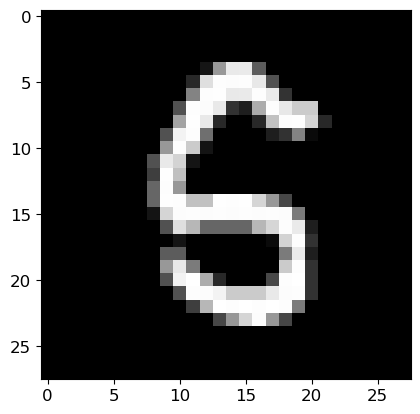

In [13]:
plt.imshow(X_train[2][:,:,0],cmap='gray')
plt.show()

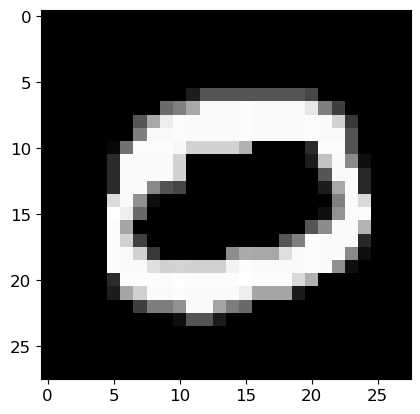

In [14]:
plt.imshow(X_test[1][:,:,0],cmap='gray')
plt.show()

### Defining custom Functions to be used for the creating a model
#### Random normal - initializer
#### (as done in W4 ) my_positive weights - contraints , Regularizer- my_l1_regularizer, activation - Leaky_relu

In [15]:
def random_normal(shape, mean=0.0, stddev=1.0, dtype=tf.float32):
    return tf.random.normal(shape, mean=mean, stddev=stddev)

In [16]:
def leaky_relu(z, alpha=0.01): 
    return tf.maximum(alpha*z, z)

In [17]:
def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

In [18]:
def my_positive_weights(weights): 
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

### Adding Standardization layer using lambda
#### then using built-in and custom functions to builld the model 

In [19]:
means = np.mean(X_train, axis=0)
stds = np.std(X_train, axis=0)
eps = keras.backend.epsilon()
model = keras.models.Sequential([
    keras.layers.Lambda(lambda inputs: (inputs - means) / (stds + eps),input_shape=[28,28,1]),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu', kernel_regularizer=my_l1_regularizer),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(256, activation='relu', kernel_regularizer=my_l1_regularizer),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=my_l1_regularizer),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax'),
    keras.layers.Dense(10, activation=leaky_relu,
                       kernel_regularizer=my_l1_regularizer,
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=random_normal),
]) 

Metal device set to: Apple M1 Pro


2023-03-09 14:08:25.853064: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-09 14:08:25.853158: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Creating another model using CNN as done in W6

In [20]:
model_CNN = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation='relu', padding='same',
                        input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

In [21]:
model.layers

### Model summary

### Model 1

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 28, 28, 1)         0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                        

### Model 2

In [23]:
model_CNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        3200      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 128)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 256)        

In [24]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer='adam',
              metrics=["accuracy"])

In [25]:
model_CNN.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [26]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, LearningRateScheduler

In [27]:
# I am using 3 types of callback to save the best model, stop the training of there is no improvement and schedule the learning rate at specific points
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001, mode='min', verbose=1)
def scheduler(epoch):
    if epoch < 10:
        return 0.001
    else:
        return 0.001 * tf.math.exp(0.1 * (10 - epoch))

lr_scheduler = LearningRateScheduler(scheduler)

### Fitting the model we created to out training dataset 

In [28]:
history = model.fit(X_train, y_train,epochs=10,callbacks=[checkpoint, early_stop, reduce_lr, lr_scheduler])

Epoch 1/10


2023-03-09 14:08:26.703213: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-09 14:08:27.091535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


985/985 [==============================] - 16s 13ms/step - loss: 33.5472 - accuracy: 0.4924 - lr: 0.0010
Epoch 2/10
985/985 [==============================] - 12s 12ms/step - loss: 20.5755 - accuracy: 0.5696 - lr: 0.0010
Epoch 3/10
985/985 [==============================] - 12s 13ms/step - loss: 16.1529 - accuracy: 0.6771 - lr: 0.0010
Epoch 4/10
985/985 [==============================] - 12s 12ms/step - loss: 12.5873 - accuracy: 0.6852 - lr: 0.0010
Epoch 5/10
985/985 [==============================] - 12s 12ms/step - loss: 11.7383 - accuracy: 0.6948 - lr: 0.0010
Epoch 6/10
985/985 [==============================] - 11s 12ms/step - loss: 9.7492 - accuracy: 0.7140 - lr: 0.0010
Epoch 7/10
985/985 [==============================] - 12s 12ms/step - loss: 11.4770 - accuracy: 0.7258 - lr: 0.0010
Epoch 8/10
985/985 [==============================] - 12s 12ms/step - loss: 9.0637 - accuracy: 0.7693 - lr: 0.0010
Epoch 9/10
985/985 [==============================] - 12s 12ms/step - loss: 9.2979 - 

In [29]:
history_CNN = model_CNN.fit(X_train, y_train,epochs=10,callbacks=[checkpoint, early_stop, reduce_lr, lr_scheduler])

Epoch 1/10


2023-03-09 14:10:28.933881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


985/985 [==============================] - 16s 14ms/step - loss: 2.2973 - accuracy: 0.1246 - lr: 0.0010
Epoch 2/10
985/985 [==============================] - 14s 14ms/step - loss: 2.2827 - accuracy: 0.1934 - lr: 0.0010
Epoch 3/10
985/985 [==============================] - 14s 14ms/step - loss: 2.2485 - accuracy: 0.2329 - lr: 0.0010
Epoch 4/10
985/985 [==============================] - 14s 14ms/step - loss: 2.1020 - accuracy: 0.3130 - lr: 0.0010
Epoch 5/10
985/985 [==============================] - 14s 14ms/step - loss: 1.5883 - accuracy: 0.4830 - lr: 0.0010
Epoch 6/10
985/985 [==============================] - 14s 14ms/step - loss: 1.0822 - accuracy: 0.6544 - lr: 0.0010
Epoch 7/10
985/985 [==============================] - 14s 14ms/step - loss: 0.7735 - accuracy: 0.7649 - lr: 0.0010
Epoch 8/10
985/985 [==============================] - 14s 14ms/step - loss: 0.5704 - accuracy: 0.8296 - lr: 0.0010
Epoch 9/10
985/985 [==============================] - 14s 14ms/step - loss: 0.4586 - accura

### Plotting the accuracy and loss graph for the models

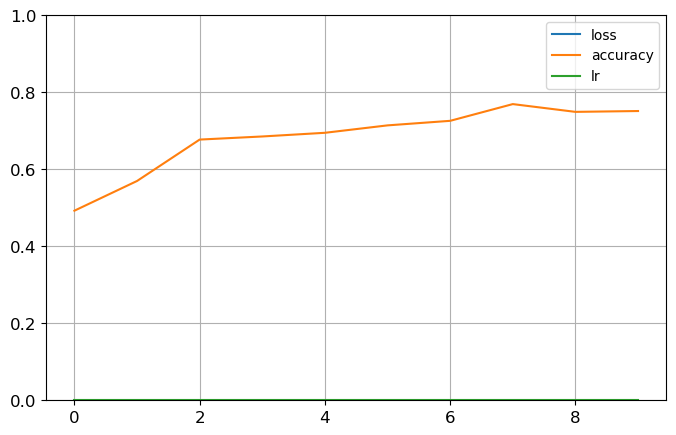

In [30]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

### Model 2

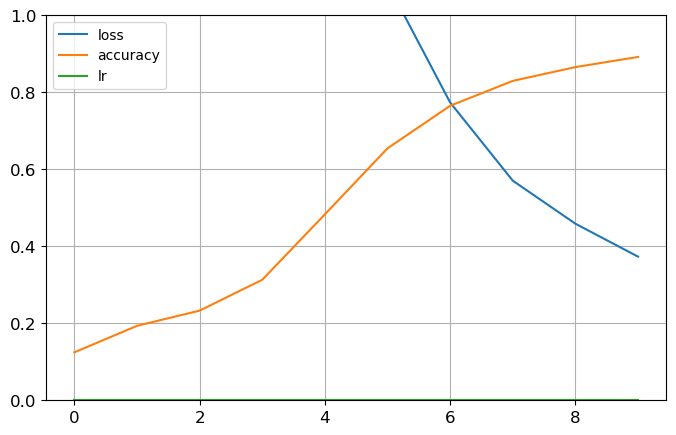

In [31]:
import pandas as pd

pd.DataFrame(history_CNN.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [32]:
test_loss, test_acc = model.evaluate(X_valid,y_valid)
print('Test accuracy:', test_acc)


 18/329 [>.............................] - ETA: 1s - loss: 7.0045 - accuracy: 0.8490

2023-03-09 14:12:49.361148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


329/329 [==============================] - 2s 6ms/step - loss: 6.9461 - accuracy: 0.8515
Test accuracy: 0.8515238165855408


### Accuracy for first model turned out to - 0.77 

In [33]:
test_loss, test_acc = model_CNN.evaluate(X_valid,y_valid)
print('Test accuracy:', test_acc)

 15/329 [>.............................] - ETA: 2s - loss: 0.2243 - accuracy: 0.9500

2023-03-09 14:12:51.612532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


329/329 [==============================] - 2s 7ms/step - loss: 0.2122 - accuracy: 0.9399
Test accuracy: 0.9399047493934631


### Accuracy for the CNN model turned out to be - 0.93

In [34]:
results = model.predict(X_test)
results = np.argmax(results,axis=1)
results = pd.Series(results,name="Label")

 65/875 [=>............................] - ETA: 1s

2023-03-09 14:12:53.991921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


875/875 [==============================] - 2s 2ms/step


In [35]:
results

0        2
1        0
2        4
3        9
4        2
        ..
27995    9
27996    7
27997    3
27998    9
27999    2
Name: Label, Length: 28000, dtype: int64

In [36]:
results_CNN = model_CNN.predict(X_test)
results_CNN = np.argmax(results_CNN,axis=1)
results_CNN = pd.Series(results_CNN,name="Label")

 32/875 [>.............................] - ETA: 4s

2023-03-09 14:12:56.244212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


875/875 [==============================] - 3s 4ms/step


In [37]:
results_CNN

0        2
1        0
2        9
3        9
4        3
        ..
27995    9
27996    7
27997    3
27998    9
27999    2
Name: Label, Length: 28000, dtype: int64

### Since the accuracy of the CNN model is better we submit the result of this in the submission file

In [38]:
submission = pd.concat([pd.Series(range(1,28001),name="ImageId"),results_CNN],axis=1)
submission.to_csv("my_submission.csv",index=False)